## Introduction


This notebook will goes beyond context() tools.

#### clarify(query, max_questions=2)
- Looks at the user’s free-text request.  
- Generates 1–2 short follow-up questions to narrow down context (e.g., “Adult or child?”, “Do you have clean cloth?”).  
- **Purpose:** prevent wrong advice by gathering minimal extra info.  

#### context(query, top_k=5)
- Searches the core knowledge pack’s vector database of text chunks.  
- Returns the top matching snippets with IDs, text, and relevance scores.  
- **Purpose:** retrieve authoritative guidance from curated docs.  

#### checklist(topic | chunks)
- Takes either a topic name (e.g., “severe bleeding”) or retrieved text chunks.  
- Converts them into a step-by-step action list with clear, ordered instructions.  
- **Purpose:** make guidance actionable and easy to follow in a stressful moment.  

#### cite(chunk_id)
- Given a chunk ID, looks up the original source document metadata.  
- Returns title, file path, page number, and date.  
- **Purpose:** provide proof and transparency for where advice came from.  

#### translate(text, target_lang="en")
- Translates user input or outputs into the specified language (default English).  
- Also indicates detected source language and a confidence score.  
- **Purpose:** support multilingual households and communities.  

#### getImage(query, top_k=3)
- Searches an image-caption vector database for diagrams/photos relevant to the query.  
- Returns likely matches with captions and file paths.  
- **Purpose:** give visual reinforcement (e.g., bandage diagrams, water purification images).  

#### knowledgeMeta()
- Reads pack metadata (from a manifest file).  
- Returns the current version and last-updated date of the knowledge pack.  
- **Purpose:** build trust by showing how recent and reliable the knowledge is.  

###  Setting up paths and loading vector store

In [2]:
# === 0) Imports & manifest ===
from pathlib import Path
import yaml, json
from typing import Optional, List, Dict
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.tools import tool
from langchain.schema import Document

# If you want the prebuilt ReAct agent:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

# If you prefer to also expose tools directly on the LLM:
from langchain.chat_models import init_chat_model

# --- Set your pack root + manifest ---
ROOT = Path("/Users/ktejwani/Personal CS Projects/Summer 2025/Offline AI Kiosk/Offline-AI-Kiosk/first_aid_pack_demo_v2")
MANIFEST = ROOT / "manifest.yaml"

with open(MANIFEST, "r", encoding="utf-8") as f:
    manifest = yaml.safe_load(f)

# --- Resolve FAISS paths from manifest ---
faiss_dir = ROOT / manifest["precomputed_indices"]["text"]["faiss"]["dir"]

# --- Create embeddings *matching the store* ---
embed_model_name = manifest["embedding_config"]["text"]["model"]     # e.g., "granite-embedding:30m"
emb = OllamaEmbeddings(model=embed_model_name)

# --- Load FAISS store + retriever ---
vs = FAISS.load_local(str(faiss_dir), emb, allow_dangerous_deserialization=True)
retriever = vs.as_retriever(search_kwargs={"k": 4})  # default k; tool will override if provided





### Defining helper and context() Tool  

In [ ]:
# === 1) Helpers ===
def format_chunk(doc: Document, max_chars: int = 400) -> Dict:
    """Return a dict with compact text + key metadata for prompting & audit."""
    txt = doc.page_content.strip()
    if len(txt) > max_chars:
        txt = txt[:max_chars].rstrip() + " …"
    m = doc.metadata
    return {
        "id": m.get("chunk_id"),
        "topic_id": m.get("topic_id"),
        "file_id": m.get("file_id"),
        "locale": m.get("locale"),
        "path": m.get("path"),
        "citations": [c.get("title", "") for c in m.get("citations", [])],
        "text": txt
    }

def format_context_block(chunks: List[Dict]) -> str:
    """Human/LLM-friendly context block the agent can drop into its reasoning."""
    lines = []
    lines.append("### Retrieved Context (use only what is relevant)")
    for i, c in enumerate(chunks, 1):
        cite_str = "; ".join([t for t in c["citations"] if t]) or "—"
        head = f"[{i}] {c['topic_id']} · {c['file_id']} · {c['locale']} · {c['path']}"
        lines.append(head)
        lines.append(c["text"])
        lines.append(f"Source(s): {cite_str}")
        lines.append("")  # blank line
    return "\n".join(lines).strip()


# === 2) The @tool: context() ===
@tool
def context(
    query: str,
    k: int = 4,
    topic_id: Optional[str] = None,
    locale: Optional[str] = None
) -> dict:
    """
    Retrieve up to k relevant knowledge-pack chunks for 'query' and return a formatted
    context block + structured per-chunk data for citations. You must use this tool for any prompt that is 
    important to wellbeing or safety of user. 

    Args:
        query: Natural language question or keywords.
        k: Top-k chunks to return (default 4).
        topic_id: Optional manifest topic filter (e.g., 'bleed-control').
        locale: Optional locale filter (e.g., 'hi_en' or 'en').

    Returns:
        {
          "query": str,
          "k": int,
          "filters": {"topic_id":..., "locale":...},
          "context_block": str,     # pasteable into prompts
          "chunks": [ {id, topic_id, file_id, path, locale, citations[], text}, ... ]
        }
    """
    # Build a metadata filter if provided
    _filter = {}
    # if topic_id:
    #     _filter["topic_id"] = topic_id
    # if locale:
    #     _filter["locale"] = locale

    # Run retrieval (override k)
    local_ret = vs.as_retriever(search_kwargs={"k": k})
    hits: List[Document] = local_ret.invoke(query) if not _filter else local_ret.invoke(query, filter=_filter)

    formatted = [format_chunk(d) for d in hits]
    ctx_block = format_context_block(formatted)
    return {
        "query": query,
        "k": k,
        "filters": _filter,
        "context_block": ctx_block,
        "chunks": formatted
    }


### Math Tools

In [ ]:
@tool
def add(a: float, b: float) -> float:
    """Add two numbers.
    
    Args:
        a: First float
        b: Second float
    """
    return a + b

@tool
def subtract(a: float, b: float) -> float:
    """Subtract first number by second number.

    Args:
        a: First float
        b: Second float
    """
    return a - b

@tool
def multiply(a: float, b: float) -> float:
    """Multiply two numbers.

    Args:
        a: First float
        b: Second float
    """
    return a * b

@tool
def divide(a : float, b: float) -> float:
    """Divide first number by second number.
    
    Args:
        a: First float
        b: Second float
    """
    return a/b


### Defining knowledgeMeta() tool

In [ ]:
from langchain.tools import tool
from pathlib import Path
import yaml
from typing import Optional

@tool
def knowledgeMeta(pack_dir: Optional[str] = None) -> dict:
    """
    Read a knowledge pack manifest and return metadata for trust & recency display.

    Args:
      pack_dir: Absolute or relative path to the pack folder (containing manifest.yaml).
                If omitted, uses the default ROOT pack path.
a
    Returns:
      {
        "name": str,
        "version": str,
        "date": str,
        "locales": [..],
        "topics_count": int,
        "manifest_path": str
      }
    """
    # default to your earlier ROOT if not provided
    base = Path(pack_dir) if pack_dir else ROOT
    manifest_path = base / "manifest.yaml"
    if not manifest_path.exists():
        return {"error": f"manifest.yaml not found at {manifest_path}"}

    with open(manifest_path, "r", encoding="utf-8") as f:
        m = yaml.safe_load(f)

    name = m.get("name", str(base.name))
    version = m.get("version", "unknown")
    date = m.get("date", "unknown")
    locales = m.get("locales", [])
    topics = m.get("index_of_topics", []) or []
    return {
        "name": name,
        "version": version,
        "date": date,
        "locales": locales,
        "topics_count": len(topics),
        "manifest_path": str(manifest_path)
    }


### List of Available Tools

In [8]:
# Keep a Tools list for whichever orchestration you choose:
TOOLS = [context,add,multiply,subtract,divide,knowledgeMeta]

### Setting Up LLM

In [ ]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    model="ollama:gpt-oss:20b",       
    temperature=0.2  # lower = more deterministic
)

llm_with_tools = llm.bind_tools(TOOLS) #llm_with_tools is a new wrapped llm
model = llm_with_tools

### Testing Tool Requests

In [58]:
query = "What do if bleeding?"
model.invoke(query) 


AIMessage(content='I’m not a medical professional, but if you’re experiencing bleeding, it’s important to get help right away. Here are some general steps you can consider:\n\n1. **Call for emergency help**  \n   - If the bleeding is heavy, rapid, or you’re unsure how to stop it, call emergency services (e.g., 911 in the U.S.) or your local emergency number immediately.\n\n2. **Seek professional care**  \n   - Even if the bleeding seems minor, it’s a good idea to have a healthcare provider evaluate the wound to rule out complications such as infection or deeper injury.\n\n3. **Follow any instructions from emergency responders**  \n   - If you’re on the phone with emergency services, they may give you guidance on what to do while you wait for help to arrive.\n\n4. **Keep yourself calm**  \n   - Stress and panic can increase heart rate and blood pressure, which might worsen bleeding. Try to stay as calm as possible until help arrives.\n\nIf you’re able to, keep the person (or yourself) i

### Reason - Act Agent Sim

In [ ]:
from typing import (
    Annotated, #Extra metadata
    Sequence, #generic list container
    TypedDict, #Lets you define a dictionary type with fixed keys and types
) #a dictionary type has a specific format of what key and valye types can be 
from langchain_core.messages import BaseMessage #lang chain message format (Human,Systen,AI)
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]
#define a state dictionary, 1 key names messages
#messages is a list of langchain base messages
#wrapping it in Annotated tells it to not replace entire list but use add_messages to merge it in
#The accepected value  for this dictionary will be Sequence[BaseMessage]

In [60]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_dict = {"context": context, "knowledgeMeta":knowledgeMeta,"add":add,"subtract":subtract,"divide":divide,"multiply":multiply}

tools_by_name = tools_dict


# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = SystemMessage(
        "You are a helpful AI assistant, please respond to the users query to the best of your ability!"
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

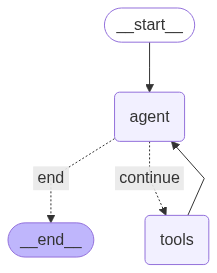

In [61]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [57]:
# Helper function for formatting the stream nicely
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {"messages": [("user", "What to do if bleed? When Knowledge updated?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What to do if bleed? When Knowledge updated?
================================== Ai Message ==================================
Tool Calls:
  context (757b769f-76fa-4147-bd50-72fbbef3b3c1)
 Call ID: 757b769f-76fa-4147-bd50-72fbbef3b3c1
  Args:
    k: 4
    locale: en
    query: bleed control first aid
    topic_id: bleed-control
================================= Tool Message =================================
Name: context

{"query": "bleed control first aid", "k": 4, "filters": {}, "context_block": "### Retrieved Context (use only what is relevant)\n[1] bleed-control \u00b7 guide-bleed-overview \u00b7 hi_en \u00b7 core/bleed-control/hi_en/bleeding_control_overview.md\n# Severe Bleeding Control\nSevere bleeding can quickly become life-threatening if not controlled.  \nApply firm direct pressure with a clean cloth or sterile gauze.  \nIf bleeding soaks through, add more cloths without removing the first.  \nE